In [2]:
import os
import numpy as np
import pandas as pd
from hpfrec import HPF
from scipy import sparse

# Set random seed for reproducibility
randseed = 26499506
print("random seed: ", randseed)
np.random.seed(randseed)

DATA_DIR = 'C:/Users/Sten Stokroos/Desktop/zelf/neural_collaborative_filtering/Data'



train_df = pd.read_csv(os.path.join(DATA_DIR, 'ml-1m.train.rating'), sep="\t", header=None, names=['userId', 'songId', 'rating'], usecols=[0, 1, 2], engine="python")
test_df = pd.read_csv(os.path.join(DATA_DIR, 'ml-1m.test.rating'), sep="\t", header=None, names=['userId', 'songId', 'rating'], usecols=[0, 1, 2], engine="python")

# Rename columns to 'UserId', 'ItemId', 'Count'
train_df = train_df.rename(columns={'userId': 'UserId', 'songId': 'ItemId', 'rating': 'Count'})
test_df = test_df.rename(columns={'userId': 'UserId', 'songId': 'ItemId', 'rating': 'Count'})

print(train_df.head)



random seed:  26499506
<bound method NDFrame.head of         UserId  ItemId  Count
0            0      32      4
1            0      34      4
2            0       4      5
3            0      35      4
4            0      30      4
...        ...     ...    ...
994166    6039    1092      5
994167    6039      41      4
994168    6039     128      5
994169    6039     323      4
994170    6039     669      4

[994171 rows x 3 columns]>


In [3]:

# Convert ratings to binary exposure data (1 if Count > 0, else 0)
train_df['Count'] = (train_df['Count'] > 0).astype(int)
test_df['Count'] = (test_df['Count'] > 0).astype(int)

# Initialize and fit the HPF model
recommender = HPF(
    k=30, a=0.3, a_prime=0.3, b_prime=1.0,
    c=0.3, c_prime=0.3, d_prime=1.0, ncores=-1,
    stop_crit='train-llk', check_every=10, stop_thr=1e-4,
    users_per_batch=None, items_per_batch=None, step_size=lambda x: 1/np.sqrt(x+2),
    maxiter=100, use_float=True, reindex=False, verbose=True,
    random_seed=None, allow_inconsistent_math=False, full_llk=False,
    alloc_full_phi=False, keep_data=True, save_folder=None,
    produce_dicts=True, keep_all_objs=True, sum_exp_trick=False
)

# Fit the model to the training data
recommender.fit(train_df)

# Get unique user and item IDs
user_ids = train_df['UserId'].unique()
item_ids = train_df['ItemId'].unique()

# Initialize an empty matrix for exposures
exposure_matrix = np.zeros((len(user_ids), len(item_ids)))

# Predict the exposure data for all user-item pairs
for i, user in enumerate(user_ids):
    exposures = recommender.predict(user=[user] * len(item_ids), item=item_ids)
    exposure_matrix[i, :] = exposures

# Convert the exposure matrix to a DataFrame
exposure_df = pd.DataFrame(exposure_matrix, index=user_ids, columns=item_ids)

# Save the exposure matrix to a CSV file
exposure_df.to_csv('C:/Users/Sten Stokroos/Desktop/Thesis2.0/zelf/xposure_matrix.csv',index = False, header = False )

print("Exposure matrix saved to exposure_matrix.csv")

**********************************
Hierarchical Poisson Factorization
**********************************

Number of users: 6040
Number of items: 3706
Latent factors to use: 30

Initializing parameters...
Allocating Phi matrix...
Initializing optimization procedure...
Iteration 10 | train llk: -2884687 | train rmse: 0.7964
Iteration 20 | train llk: -2554191 | train rmse: 0.7387
Iteration 30 | train llk: -2390420 | train rmse: 0.6958
Iteration 40 | train llk: -2359765 | train rmse: 0.6890
Iteration 50 | train llk: -2347088 | train rmse: 0.6862
Iteration 60 | train llk: -2340591 | train rmse: 0.6849
Iteration 70 | train llk: -2336932 | train rmse: 0.6842
Iteration 80 | train llk: -2334743 | train rmse: 0.6838


Optimization finished
Final log-likelihood: -2334743
Final RMSE: 0.6838
Minutes taken (optimization part): 0.9

Exposure matrix saved to exposure_matrix.csv


In [1]:
import os
import numpy as np
import pandas as pd
from hpfrec import HPF
import heapq
import math
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split

# Set random seed for reproducibility
randseed = 42
print("random seed: ", randseed)
np.random.seed(randseed)

dir_r3 = 'C:/Users/Sten Stokroos/Desktop/NEW/zelf/Data/out'
dir_ml = 'C:/Users/Sten Stokroos/Desktop/NEW/zelf/Data/in'

def choose_data(dat):
    # DATA_DIR = 'C:/Users/Sten Stokroos/Desktop/zelf/neural_collaborative_filtering/Data'

    if dat == 'r3':
        train = pd.read_csv(os.path.join(dir_r3, 'r3_train.csv'), sep="\t", header=None, names=['userId', 'songId', 'rating'], usecols=[0, 1, 2], engine="python")
        test = pd.read_csv(os.path.join(dir_r3, 'r3_test.csv'), sep="\t", header=None, names=['userId', 'songId', 'rating'], usecols=[0, 1, 2], engine="python")
    elif dat == 'ml':
        ml_full = pd.read_csv(os.path.join(dir_r3, 'ml-1m_full.csv'), sep="\t", header=None, names=['userId', 'songId', 'rating'], usecols=[0, 1, 2], engine="python")
        train, test = train_test_split(ml_full, test_size = 0.1)
    else:
        print('Wrong data input')

    return train, test

ml = 'ml'
yahoo = 'r3'

train_df, test_df = choose_data(ml)
train_df, vad_df =  train_test_split(train_df, test_size = 0.1) 




# Rename columns to 'UserId', 'ItemId', 'Count'
train_df = train_df.rename(columns={'userId': 'UserId', 'songId': 'ItemId', 'rating': 'Count'})
vad_df = vad_df.rename(columns={'userId': 'UserId', 'songId': 'ItemId', 'rating': 'Count'})
test_df = test_df.rename(columns={'userId': 'UserId', 'songId': 'ItemId', 'rating': 'Count'})

# Convert ratings to binary exposure data (1 if Count > 0, else 0)
train_df['Count'] = (train_df['Count'] > 0).astype(int)
test_df['Count'] = (test_df['Count'] > 0).astype(int)
vad_df['Count'] = (vad_df['Count'] > 0).astype(int)


# Get unique user and item IDs
all_observed_df = pd.concat([train_df, vad_df, test_df])
user_ids = all_observed_df['UserId'].unique()
item_ids = all_observed_df['ItemId'].unique()
num_users = len(user_ids)
num_items = len(item_ids)


def load_negative_file(filename):
    negativeList = []
    with open(filename, "r") as f:
        line = f.readline()
        while line != None and line != "":
            arr = line.split("\t")
            negatives = []
            for x in arr[1:]:
                negatives.append(int(x))
            negativeList.append(negatives)
            line = f.readline()
    return negativeList

negative_samples_file = 'C:/Users/Sten Stokroos/Desktop/NEW/zelf/Data/out/ml_negatives.csv'
test_negatives = load_negative_file(negative_samples_file)

# Define evaluation functions
def getNDCG(ranklist, gtItem):
    for i in range(len(ranklist)):
        item = ranklist[i]
        if item == gtItem:
            return math.log(2) / math.log(i + 2)
    return 0



def eval_one_rating(idx, model, test_ratings, test_negatives, topk):
    rating = test_ratings[idx]
    user = rating[0]
    gtItem = rating[1]
    items = test_negatives[idx]
    items.append(gtItem)
    
    # Get prediction scores
    map_item_score = {}
    users = np.full(len(items), user, dtype='int32')
    predictions = model.predict(user=users, item=np.array(items))
    
    for i in range(len(items)):
        item = items[i]
        map_item_score[item] = predictions[i]
    items.pop()
    
    # Evaluate top rank list
    ranklist = heapq.nlargest(topk, map_item_score, key=map_item_score.get)
    ndcg = getNDCG(ranklist, gtItem)
    return ndcg


k_values = [5, 10, 20, 50]
performance = []
log_likelihoods = []

# Prepare test ratings
test_ratings = test_df[['UserId', 'ItemId']].values.tolist()

for k in k_values:
    print(f"Training HPF model with k={k}...")
    recommender = HPF(
        k=k, a=0.3, a_prime=0.3, b_prime=1.0,
        c=0.3, c_prime=0.3, d_prime=1.0, ncores=-1,
        stop_crit='val-llk', check_every=10, stop_thr=1e-3,
        users_per_batch=None, items_per_batch=None, step_size=lambda x: 1/np.sqrt(x+2),
        maxiter=100, use_float=True, reindex=False, verbose=True,
        random_seed=None, allow_inconsistent_math=False, full_llk=False,
        alloc_full_phi=False, keep_data=True, save_folder=None,
        produce_dicts=True, keep_all_objs=True, sum_exp_trick=False
    )

    # Fit the model to the training data
    recommender.fit(train_df, vad_df)
    topk = 10

    # Calculate log-likelihood on the validation set
    llk = recommender.eval_llk(vad_df)
    log_likelihoods.append(llk['llk'])
    print(f"Log-likelihood for k={k}: {llk['llk']}")

    # Evaluate the model using NDCG
    ndcg_scores = [eval_one_rating(i, recommender, test_ratings, test_negatives, topk) for i in tqdm(range(len(test_ratings)))]
    avg_ndcg = np.mean(ndcg_scores)
    performance.append(avg_ndcg)
    print(f"Average NDCG for k={k}: {avg_ndcg}")

# Plot the log-likelihood
plt.figure(figsize=(10, 6))
plt.plot(k_values, log_likelihoods, marker='o')
plt.xlabel('Number of Latent Factors (k)')
plt.ylabel('Log-Likelihood')
plt.title('Log-Likelihood of HPF Model at Different Values of k')
plt.grid(True)
plt.show()

# Plot the performance
plt.figure(figsize=(10, 6))
plt.plot(k_values, performance, marker='o')
plt.xlabel('Number of Latent Factors (k)')
plt.ylabel('Average NDCG')
plt.title('Performance of HPF Model at Different Values of k')
plt.grid(True)
plt.show()



# # Initialize an empty matrix for exposures
# exposure_matrix = np.zeros((len(user_ids), len(item_ids)))

# # Predict the exposure data for all user-item pairs
# for i, user in enumerate(user_ids):
#     exposures = recommender.predict(user=[user] * len(item_ids), item=item_ids)
#     exposure_matrix[i, :] = exposures

# # Convert the exposure matrix to a DataFrame
# exposure_df = pd.DataFrame(exposure_matrix, index=user_ids, columns=item_ids)

# Save the exposure matrix to a CSV file
# exposure_df.to_csv('C:/Users/Sten Stokroos/Desktop/NEW/zelf/Data/exposure_output/exposure_matrix.csv',index = False, header = False )



random seed:  42


KeyboardInterrupt: 

random seed:  42
Training HPF model with k=10...
**********************************
Hierarchical Poisson Factorization
**********************************

Number of users: 6040
Number of items: 3706
Latent factors to use: 10

Initializing parameters...
Allocating Phi matrix...
Initializing optimization procedure...


c:\Users\Public\ana\Lib\site-packages\hpfrec\__init__.py:469: UserWarning: 'counts_df' contains observations with a count value less than 1, these will be ignored. Any user or item associated exclusively with zero-value observations will be excluded. If using 'reindex=False', make sure that your data still meets the necessary criteria. If you still want to use these observations, set 'stop_crit' to 'diff-norm' or 'maxiter'.
  warnings.warn(
c:\Users\Public\ana\Lib\site-packages\hpfrec\__init__.py:510: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.input_df['Count'] = self.input_df["Count"].astype(cython_loops.c_real_t)


Iteration 10 | val llk: -226796 | val rmse: 0.8509
Iteration 20 | val llk: -208296 | val rmse: 0.8227
Iteration 30 | val llk: -202979 | val rmse: 0.8065
Iteration 40 | val llk: -202606 | val rmse: 0.8050
Iteration 50 | val llk: -202416 | val rmse: 0.8045


Optimization finished
Final log-likelihood: -202416
Final RMSE: 0.8045
Minutes taken (optimization part): 0.1

Log-likelihood for k=10: -202416.01765838958


100%|██████████| 100022/100022 [00:35<00:00, 2785.88it/s]


Average NDCG for k=10: 0.42473511797661173
Observed Log-Likelihood for k=10: -363880.0683436818
Replicated Log-Likelihood 1/50 for k=10: -76658.18302777263
Replicated Log-Likelihood 2/50 for k=10: -76658.18302777263
Replicated Log-Likelihood 3/50 for k=10: -76658.18302777263
Replicated Log-Likelihood 4/50 for k=10: -76658.18302777263
Replicated Log-Likelihood 5/50 for k=10: -76658.18302777263
Replicated Log-Likelihood 6/50 for k=10: -76658.18302777263
Replicated Log-Likelihood 7/50 for k=10: -76658.18302777263
Replicated Log-Likelihood 8/50 for k=10: -76658.18302777263
Replicated Log-Likelihood 9/50 for k=10: -76658.18302777263
Replicated Log-Likelihood 10/50 for k=10: -76658.18302777263
Replicated Log-Likelihood 11/50 for k=10: -76658.18302777263
Replicated Log-Likelihood 12/50 for k=10: -76658.18302777263
Replicated Log-Likelihood 13/50 for k=10: -76658.18302777263
Replicated Log-Likelihood 14/50 for k=10: -76658.18302777263
Replicated Log-Likelihood 15/50 for k=10: -76658.1830277726

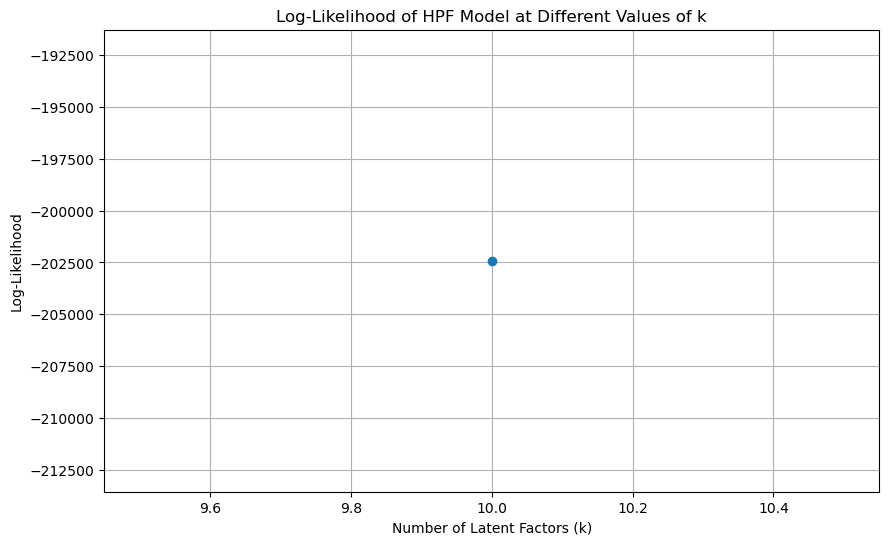

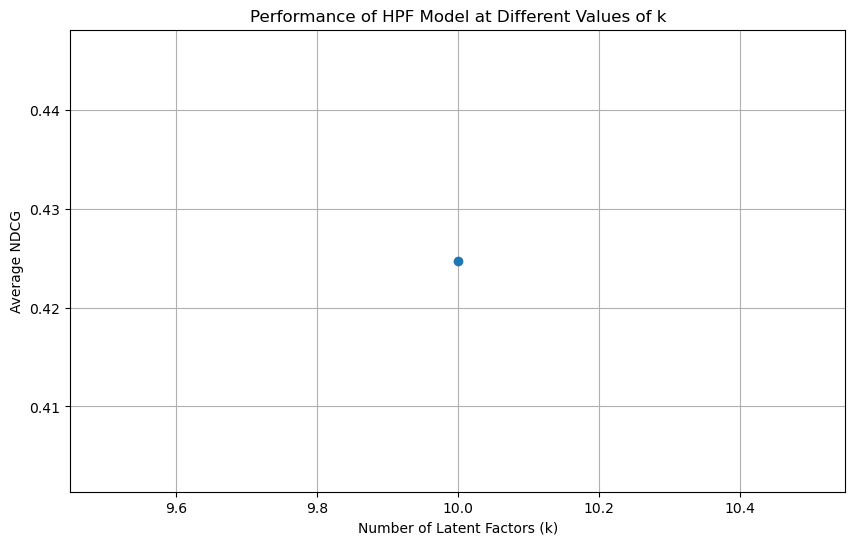

In [20]:
import os
import numpy as np
import pandas as pd
from hpfrec import HPF
import heapq
import math
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from scipy.stats import poisson, norm

# Set random seed for reproducibility
randseed = 42
print("random seed: ", randseed)
np.random.seed(randseed)

dir_r3 = 'C:/Users/Sten Stokroos/Desktop/NEW/zelf/Data/out'
dir_ml = 'C:/Users/Sten Stokroos/Desktop/NEW/zelf/Data/in'

def choose_data(dat):
    # DATA_DIR = 'C:/Users/Sten Stokroos/Desktop/zelf/neural_collaborative_filtering/Data'

    if dat == 'r3':
        train = pd.read_csv(os.path.join(dir_r3, 'r3_train.csv'), sep="\t", header=None, names=['userId', 'songId', 'rating'], usecols=[0, 1, 2], engine="python")
        test = pd.read_csv(os.path.join(dir_r3, 'r3_test.csv'), sep="\t", header=None, names=['userId', 'songId', 'rating'], usecols=[0, 1, 2], engine="python")
    elif dat == 'ml':
        ml_full = pd.read_csv(os.path.join(dir_r3, 'ml-1m_full.csv'), sep="\t", header=None, names=['userId', 'songId', 'rating'], usecols=[0, 1, 2], engine="python")
        train, test = train_test_split(ml_full, test_size = 0.1)
    else:
        print('Wrong data input')

    return train, test

ml = 'ml'
yahoo = 'r3'

train_df, test_df = choose_data(ml)
train_df, vad_df =  train_test_split(train_df, test_size = 0.1) 




# Rename columns to 'UserId', 'ItemId', 'Count'
train_df = train_df.rename(columns={'userId': 'UserId', 'songId': 'ItemId', 'rating': 'Count'})
vad_df = vad_df.rename(columns={'userId': 'UserId', 'songId': 'ItemId', 'rating': 'Count'})
test_df = test_df.rename(columns={'userId': 'UserId', 'songId': 'ItemId', 'rating': 'Count'})

# Convert ratings to binary exposure data (1 if Count > 0, else 0)
train_df['Count'] = (train_df['Count'] > 0).astype(int)
test_df['Count'] = (test_df['Count'] > 0).astype(int)
vad_df['Count'] = (vad_df['Count'] > 0).astype(int)


# Get unique user and item IDs
all_observed_df = pd.concat([train_df, vad_df, test_df])
user_ids = all_observed_df['UserId'].unique()
item_ids = all_observed_df['ItemId'].unique()
num_users = len(user_ids)
num_items = len(item_ids)

# Define the portion of data to hold out
holdout_portion = 0.2
n_holdout = int(holdout_portion * train_df.shape[0])

# Randomly select indices to hold out
holdout_indices = np.random.choice(train_df.index, size=n_holdout, replace=False)
holdout_df = train_df.loc[holdout_indices]
train_df.loc[holdout_indices, 'Count'] = 0  # Mask held out data in training set
# vad_df.loc[holdout_indices, 'Count'] = 0 

# Prepare held-out data
heldout_users = holdout_df['UserId'].values
heldout_items = holdout_df['ItemId'].values
heldout_counts = holdout_df['Count'].values

heldout_eval_df = holdout_df[['UserId', 'ItemId', 'Count']]

def load_negative_file(filename):
    negativeList = []
    with open(filename, "r") as f:
        line = f.readline()
        while line != None and line != "":
            arr = line.split("\t")
            negatives = []
            for x in arr[1:]:
                negatives.append(int(x))
            negativeList.append(negatives)
            line = f.readline()
    return negativeList

negative_samples_file = 'C:/Users/Sten Stokroos/Desktop/NEW/zelf/Data/out/ml_negatives.csv'
test_negatives = load_negative_file(negative_samples_file)

# Define evaluation functions
def getNDCG(ranklist, gtItem):
    for i in range(len(ranklist)):
        item = ranklist[i]
        if item == gtItem:
            return math.log(2) / math.log(i + 2)
    return 0



def eval_one_rating(idx, model, test_ratings, test_negatives, topk):
    rating = test_ratings[idx]
    user = rating[0]
    gtItem = rating[1]
    items = test_negatives[idx]
    items.append(gtItem)
    
    # Get prediction scores
    map_item_score = {}
    users = np.full(len(items), user, dtype='int32')
    predictions = model.predict(user=users, item=np.array(items))
    
    for i in range(len(items)):
        item = items[i]
        map_item_score[item] = predictions[i]
    items.pop()
    
    # Evaluate top rank list
    ranklist = heapq.nlargest(topk, map_item_score, key=map_item_score.get)
    ndcg = getNDCG(ranklist, gtItem)
    return ndcg


k_values = [10]
performance = []
log_likelihoods = []




# Prepare test ratings
test_ratings = test_df[['UserId', 'ItemId']].values.tolist()

for k in k_values:
    print(f"Training HPF model with k={k}...")
    recommender = HPF(
        k=k, a=0.3, a_prime=0.3, b_prime=1.0,
        c=0.3, c_prime=0.3, d_prime=1.0, ncores=-1,
        stop_crit='val-llk', check_every=10, stop_thr=1e-3,
        users_per_batch=None, items_per_batch=None, step_size=lambda x: 1/np.sqrt(x+2),
        maxiter=100, use_float=True, reindex=False, verbose=True,
        random_seed=None, allow_inconsistent_math=False, full_llk=False,
        alloc_full_phi=False, keep_data=True, save_folder=None,
        produce_dicts=True, keep_all_objs=True, sum_exp_trick=False
    )

    # Fit the model to the training data
    recommender.fit(train_df, vad_df)
    topk = 10

    # Calculate log-likelihood on the validation set
    llk = recommender.eval_llk(vad_df)
    log_likelihoods.append(llk['llk'])
    print(f"Log-likelihood for k={k}: {llk['llk']}")

    # Evaluate the model using NDCG
    ndcg_scores = [eval_one_rating(i, recommender, test_ratings, test_negatives, topk) for i in tqdm(range(len(test_ratings)))]
    avg_ndcg = np.mean(ndcg_scores)
    performance.append(avg_ndcg)
    print(f"Average NDCG for k={k}: {avg_ndcg}")

    # Generate replicated datasets
    n_rep = 50  # Number of replicated datasets to generate
    replicated_heldout_counts = np.zeros((n_rep, len(heldout_users)))

    for i in range(n_rep):
        replicated_counts = recommender.predict(user=heldout_users, item=heldout_items)
        replicated_heldout_counts[i] = replicated_counts

    # Compute expected log likelihood for held-out data and replicated data
    def expected_log_prob(data_df):
        llk_dict = recommender.eval_llk(data_df)
        return llk_dict['llk']

    obs_log_prob = expected_log_prob(heldout_eval_df)
    print(f"Observed Log-Likelihood for k={k}: {obs_log_prob}")

    rep_log_probs = []
    for i in range(n_rep):
        rep_eval_df = pd.DataFrame({
            'UserId': heldout_users,
            'ItemId': heldout_items,
            'Count': replicated_heldout_counts[i]
        })
        rep_llk = expected_log_prob(rep_eval_df)
        rep_log_probs.append(rep_llk)
        print(f"Replicated Log-Likelihood {i+1}/{n_rep} for k={k}: {rep_llk}")

    # Calculate predictive score
    predictive_score = np.mean([rep_log_prob < obs_log_prob for rep_log_prob in rep_log_probs])
    print(f"Predictive Score for k={k}: {predictive_score}")



# Plot the log-likelihood
plt.figure(figsize=(10, 6))
plt.plot(k_values, log_likelihoods, marker='o')
plt.xlabel('Number of Latent Factors (k)')
plt.ylabel('Log-Likelihood')
plt.title('Log-Likelihood of HPF Model at Different Values of k')
plt.grid(True)
plt.show()

# Plot the performance
plt.figure(figsize=(10, 6))
plt.plot(k_values, performance, marker='o')
plt.xlabel('Number of Latent Factors (k)')
plt.ylabel('Average NDCG')
plt.title('Performance of HPF Model at Different Values of k')
plt.grid(True)
plt.show()



